# Packages

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(palette="dark")

# query with CasJobs, the primary database for the SDSS
import SciServer.CasJobs as CasJobs     

# Machine Learning packages 
from sklearn import (linear_model,pipeline,model_selection,preprocessing,
                    tree,ensemble,svm,decomposition,multioutput,metrics,
                    feature_selection,neural_network,cluster)
import tensorflow as tf
from tensorflow import keras

# SQL Query

The is taken from http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx.

Two tables:
    
    1. specObjAll
    2. photoObjAll


<ins> TABLE  SpecObjAll </ins>

Contains the measured parameters for a spectrum.
This is a base table containing ALL the spectroscopic information, including a lot of duplicate and bad data. Use the SpecObj view instead, which has the data properly filtered for cleanliness. These tables contain both the BOSS and SDSS spectrograph data. NOTE: The RA and Dec in this table refer to the DR8 coordinates, which have errors in the region north of 41 deg in Dec. This change does not affect the matching to the photometric catalog.

<ins> TABLE  PhotoObjAll </ins>

The full photometric catalog quantities for SDSS imaging.
This table contains one entry per detection, with the associated photometric parameters measured by PHOTO, and astrometrically and photometrically calibrated.
The table has the following views:

PhotoObj: all primary and secondary objects; essentially this is the view you should use unless you want a specific type of object.

PhotoPrimary: all photo objects that are primary (the best version of the object).

- Star: Primary objects that are classified as stars.
- Galaxy: Primary objects that are classified as galaxies.
- Sky:Primary objects which are sky samples.
- Primary objects which are no0ne of the above

PhotoSecondary: all photo objects that are secondary (secondary detections)

PhotoFamily: all photo objects which are neither primary nor secondary (blended)
The table has indices that cover the popular columns.

First search will just return the columns in both tables and a single row to show the value to determine the type 

In [2]:
# Find objects in the Sloan Digital Sky Survey's Data Release 16.
#
# Query the Sloan Digital Sky Serveys' Data Release 16.
# For the database schema and documentation see http://skyserver.sdss.org/dr16
#
# store the query in an object called "query"

query = (
    """
    SELECT TOP 3 *
        FROM specObjAll
    """
)

# execute the query to SDSS dr16 and store it in "test"
df = CasJobs.executeQuery(query,"dr16")
print('specObj table')
print(df.shape)
df.info()

specObj table
(3, 195)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Columns: 195 entries, specObjID to img
dtypes: float64(89), int64(85), object(21)
memory usage: 4.7+ KB


In [3]:
for key in df.keys():
    if key == 'img': continue
    print('%s: %s'%(key,df[key][0]))

specObjID: 299489676975171584
bestObjID: 1237648720142401611
fluxObjID: 1237648720142401611
targetObjID: 284722522357889
plateID: 299489402097264640
sciencePrimary: 0
sdssPrimary: 0
legacyPrimary: 0
seguePrimary: 0
segue1Primary: 0
segue2Primary: 0
bossPrimary: 0
bossSpecObjID: 0
firstRelease: dr7
survey: sdss
instrument: SDSS
programname: legacy
chunk: chunk4
platerun: chunk4
mjd: 51602
plate: 266
fiberID: 1
run1d: 
run2d: 26
tile: 122
designID: -1
legacy_target1: 96
legacy_target2: 0
special_target1: 0
special_target2: 0
segue1_target1: 0
segue1_target2: 0
segue2_target1: 0
segue2_target2: 0
boss_target1: 0
eboss_target0: 0
eboss_target1: 0
eboss_target2: 0
eboss_target_id: 0
ancillary_target1: 0
ancillary_target2: 0
thing_id_targeting: 0
thing_id: 0
primTarget: 96
secTarget: 0
spectrographID: 1
sourceType: GALAXY
targetType: SCIENCE
ra: 146.71421
dec: -1.0413043
cx: -0.835805446776262
cy: 0.548724876759158
cz: -0.018173188074197
xFocal: 179.0361
yFocal: -240.3215
lambdaEff: 5000
blu

In [4]:
query = (
    """
    SELECT TOP 3 *
        FROM photoObjAll
    """
)

# execute the query to SDSS dr16 and store it in "test"
df = CasJobs.executeQuery(query,"dr16")
print('photoObj table')
print(df.shape)
df.info()

photoObj table
(3, 509)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Columns: 509 entries, objID to TAI_z
dtypes: float64(449), int64(60)
memory usage: 12.1 KB


In [5]:
for key in df.keys():
    print('%s: %s'%(key,df[key][0]))

objID: 1237645876861272065
skyVersion: 2
run: 94
rerun: 301
camcol: 1
field: 11
obj: 1
mode: 3
nChild: 4
type: 3
clean: 0
probPSF: 0
insideMask: 0
flags: 488262955569166
rowc: 55.68903
rowcErr: 1.008007
colc: 1909.373
colcErr: 1.006504
rowv: -9999.0
rowvErr: -9999.0
colv: -9999.0
colvErr: -9999.0
rowc_u: 62.32717
rowc_g: 69.62091
rowc_r: 55.62588
rowc_i: 59.49052
rowc_z: 65.05569
rowcErr_u: 1.0
rowcErr_g: 1.0
rowcErr_r: 1.0
rowcErr_i: 1.0
rowcErr_z: 1.0
colc_u: 1911.868
colc_g: 1914.038
colc_r: 1909.323
colc_i: 1906.61
colc_z: 1908.747
colcErr_u: 1.0
colcErr_g: 1.0
colcErr_r: 1.0
colcErr_i: 1.0
colcErr_z: 1.0
sky_u: 1.839297
sky_g: 2.126877
sky_r: 5.502751
sky_i: 11.86236
sky_z: 39.01072
skyIvar_u: 117135.3
skyIvar_g: 69655.75
skyIvar_r: 45238.57
skyIvar_i: 5403.692
skyIvar_z: 5560.571
psfMag_u: 10.93528
psfMag_g: 9.658268
psfMag_r: 14.40427
psfMag_i: 9.333409
psfMag_z: 11.06126
psfMagErr_u: 0.0003566265
psfMagErr_g: 9.074066e-05
psfMagErr_r: 0.0177245
psfMagErr_i: 9.235229e-05
psfMagE

##  Select columns and join tables

### specObjAll

    1. ra:    DR8 Right ascension of fiber, J2000
    2. dec:   DR8 Declination of fiber, J2000
    3. z:     Final Redshift
    4. cx:    x of Normal unit vector in J2000
    5. cy:    y of Normal unit vector in J2000
    6. cz:    z of Normal unit vector in J2000
    7. class: Spectroscopic class (GALAXY, QSO, or STAR)
    Join on bestObjID 
    
### photoObjAll

    1. dered_u: Simplified mag, corrected for extinction: modelMag-extinction
    2. dered_g: "" 
    3. dered_r: ""
    4. dered_i: ""
    5. dered_z: ""
    6. u: Shorthand alias for modelMag
    7. g: ""
    8. r: ""
    7. i: ""
    Join on ObjID

In [6]:
query = (
    """
    SELECT TOP 20 s.ra, s.dec, s.z, s.cx, s.cy, s.cz, s.class,
                  p.dered_u, p.dered_g, p.dered_r, p.dered_i, 
                  p.dered_z, p.u, p.g, p.r, p.i
        FROM specObjAll AS s
    INNER JOIN photoObjAll AS p ON s.bestObjID = p.objID
    """
)

# execute the query to SDSS dr16 and store it in "test"
df = CasJobs.executeQuery(query,"dr16")
df.head(20)

,ra,dec,z,cx,cy,cz,class,dered_u,dered_g,dered_r,dered_i,dered_z,u,g,r,i
0,146.71421,-1.041304,0.021275,-0.835805,0.548725,-0.018173,GALAXY,16.91713,15.31460,14.55245,14.14041,13.83297,17.15123,15.49701,14.67864,14.23418
1,146.71421,-1.041304,0.021222,-0.835805,0.548725,-0.018173,GALAXY,16.91713,15.31460,14.55245,14.14041,13.83297,17.15123,15.49701,14.67864,14.23418
2,146.91945,-0.990492,0.213925,-0.837779,0.545736,-0.017286,GALAXY,20.18201,18.45391,17.33205,16.89840,16.59294,20.43564,18.65154,17.46877,17.00000
3,146.74413,-0.652191,0.203783,-0.836176,0.548343,-0.011383,GALAXY,20.97757,18.85416,17.52073,17.00673,16.65681,21.33301,19.13112,17.71233,17.14911
4,146.90229,-0.984913,0.652181,-0.837617,0.545988,-0.017189,QSO,19.70227,19.34294,19.28379,19.17720,19.14497,19.95123,19.53693,19.41799,19.27693
5,146.90229,-0.984913,0.652417,-0.837617,0.545988,-0.017189,QSO,19.70227,19.34294,19.28379,19.17720,19.14497,19.95123,19.53693,19.41799,19.27693
6,146.85983,-0.808902,0.126554,-0.837252,0.546635,-0.014118,GALAXY,20.53679,18.46119,17.18082,16.61607,16.14976,20.77635,18.64786,17.30996,16.71203
7,146.62857,-0.765137,0.064656,-0.835048,0.550015,-0.013354,GALAXY,19.18432,17.34647,16.50649,16.07855,15.75247,19.50005,17.59248,16.67668,16.20502
8,146.76339,-0.810433,0.448645,-0.836331,0.548043,-0.014144,GALAXY,25.08210,21.21467,19.49395,18.71828,18.23910,25.33996,21.41559,19.63294,18.82156
9,146.93861,-0.687012,2.831786,-0.838026,0.545498,-0.011990,QSO,21.29115,19.43844,19.17614,18.80836,18.56590,21.63344,19.70515,19.36065,18.94547


## Stats about the class column
There are 3 different classes: STAR, GALAXY, and QSO. Use aggregate functions such as MAX, MIN, AVG, and COUNT to return columns of import information about the data 

In [7]:
query = (
    """
    SELECT MAX(s.ra) AS max_ra,
           MAX(s.dec) AS max_dec,
           MIN(s.ra) AS min_ra,
           MIN(s.dec) AS min_dec,
           AVG(s.ra) AS mean_ra,
           AVG(s.dec) AS mean_dec
        FROM specObjAll AS s
    INNER JOIN photoObjAll AS p ON s.bestObjID = p.objID
    """
)

test = CasJobs.executeQuery(query,"dr16")
print(test.shape)
test.head(5)

(1, 6)


,max_ra,max_dec,min_ra,min_dec,mean_ra,mean_dec
0,359.99994,84.852144,0.000091,-19.702714,171.043718,24.049581


In [8]:
query = (
    """
    SELECT  
           CASE 
               WHEN s.class = 'QSO' THEN 'quasar'
               ELSE LOWER(s.class)
           END AS class,
           COUNT(s.class) AS count_class
        FROM specObjAll AS s
    INNER JOIN photoObjAll AS p ON s.bestObjID = p.objID
    GROUP BY s.class
    """
)

test = CasJobs.executeQuery(query,"dr16")
print(test.shape)
test.head(5)

(3, 2)


,class,count_class
0,galaxy,3040334
1,quasar,1098080
2,star,1103720


## Check for duplicates 

In [9]:
# this query will return a table with columns bestObjID and the count of the duplicates
# just used as a test
query = (
    """
    SELECT s.bestObjID, COUNT(*) AS count 
        FROM specObjALL AS s
    GROUP BY s.bestObjID
    HAVING COUNT(*) > 1
    """
)
# this query will just select the bestObjID column which does not have any duplicates
query = (
    """
    SELECT s.bestObjID 
        FROM specObjALL AS s
    INNER JOIN (
        SELECT bestObjID, COUNT(*) AS count 
            FROM specObjALL
        GROUP BY bestObjID
        HAVING COUNT(*) = 1 
    ) AS filter ON filter.bestObjID = s.bestObjID
      
    """
)
test = CasJobs.executeQuery(query,"dr16")
print(test.shape)
test.head()

(4150699, 1)


,bestObjID
0,1237680310696280642
1,1237680123321712830
2,1237678617422463466
3,1237669703195951177
4,1237657189836063281


There are duplicates in the data that we want to remove. Lets do a count of the different classes with the duplicates removed. Use a subquery in the where clause to remove them. The subquery is essentually the query in the previous cell and we join on the bestObjID from the table that had the duplicates removed

In [10]:
query = ( 
    """
    SELECT  
           CASE 
               WHEN s.class = 'QSO' THEN 'quasar'
               ELSE LOWER(s.class)
           END AS class,
           COUNT(s.class) AS count_class
        FROM specObjAll AS s
    INNER JOIN photoObjAll AS p ON s.bestObjID = p.objID
    WHERE s.bestObjID NOT IN (
        SELECT si.bestObjID 
            FROM specObjALL AS si
        INNER JOIN (
            SELECT bestObjID, COUNT(*) AS count 
                FROM specObjALL
            GROUP BY bestObjID
            HAVING COUNT(*) > 1
        ) AS filter ON filter.bestObjID = si.bestObjID
    )
    GROUP BY s.class
    """
)

test = CasJobs.executeQuery(query,"dr16")
print(test.shape)
test.head(5)

(3, 2)


,class,count_class
0,galaxy,2576570
1,quasar,725677
2,star,847474


This appears to be smaller than the previous search so it looks like the duplicates were removed. Will double check this here with a subsection of the data taken by filtering the ra and dec values using the WHERE clause.

In [11]:
query = (
    """
    SELECT s.bestObjID, s.ra, s.dec, s.z, s.cx, s.cy, s.cz, s.class,
           p.dered_u, p.dered_g, p.dered_r, p.dered_i, 
           p.dered_z, p.u, p.g, p.r, p.i
        FROM specObjAll AS s
    INNER JOIN photoObjAll AS p ON s.bestObjID = p.objID
    WHERE (s.ra BETWEEN 256.5 AND 259.7) AND 
          (s.dec BETWEEN 63.4 and 64.8) 
    """
)

# execute the query to SDSS dr16 and store it in "test"
df = CasJobs.executeQuery(query,"dr16")
print(df.shape)
df.duplicated('bestObjID').any()

(653, 17)


True

There appears to be duplicated values. The code below will remove duplicates and double check.

In [12]:
query = (
    """
    SELECT s.bestObjID, s.ra, s.dec, s.z, s.cx, s.cy, s.cz, s.class,
           p.dered_u, p.dered_g, p.dered_r, p.dered_i, 
           p.dered_z, p.u, p.g, p.r, p.i
    FROM specObjAll AS s
    INNER JOIN photoObjAll AS p ON s.bestObjID = p.objID
    WHERE (s.ra BETWEEN 256.5 AND 259.7) AND 
          (s.dec BETWEEN 63.4 and 64.8) AND 
          s.bestObjID NOT IN (
              SELECT si.bestObjID 
                  FROM specObjALL AS si
              INNER JOIN (
                  SELECT bestObjID, COUNT(*) AS count 
                      FROM specObjALL
                  GROUP BY bestObjID
                  HAVING COUNT(*) > 1
              ) AS filter ON filter.bestObjID = si.bestObjID
          )
    """
)

# execute the query to SDSS dr16 and store it in "test"
df = CasJobs.executeQuery(query,"dr16")
print(df.shape)
df.duplicated('bestObjID').any()

(299, 17)


False

The duplicates appear to be removed. 

## Visualize Data 

Count of the classes. The selection appears to be more skewed towards GALAXY

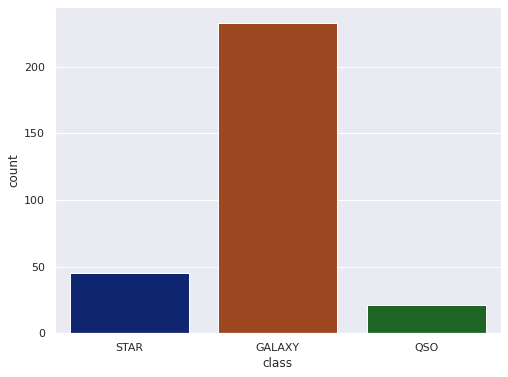

In [13]:
fig,ax = plt.subplots(figsize=(8,6))

sns.countplot(
    data=df,
    x="class"
)
plt.show()

Plot of the redshift distribution 

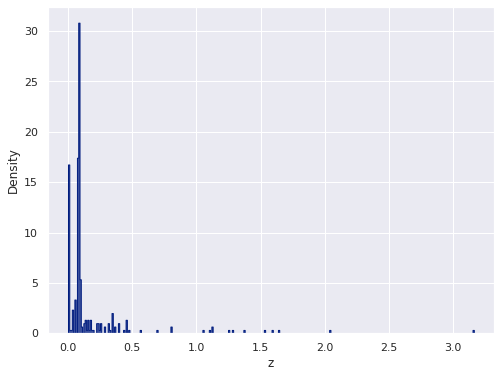

In [14]:
bins = np.linspace(df['z'].min(),df['z'].max(),318,endpoint=True)

fig,ax = plt.subplots(figsize=(8,6))
sns.histplot(
    data=df,
    x="z",
    bins=bins,
    stat="density",
    element="step"
)
#ax.set(xlim=(0,0.25))
plt.show()

Appears to be clusering around small z. Make some bins that encompass the range of the clustering


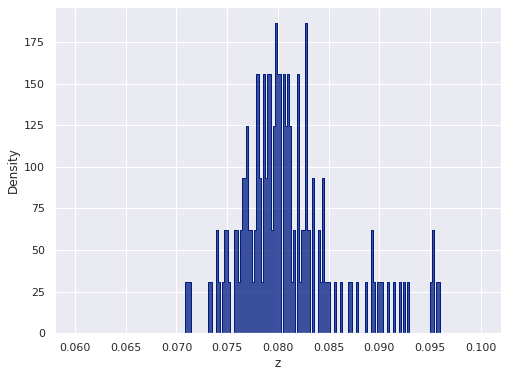

In [15]:
bins = np.linspace(0.06,0.1,200,endpoint=True)
fig,ax = plt.subplots(figsize=(8,6))
sns.histplot(
    data=df,
    x="z",
    bins=bins,
    stat="density",
    element="step")
plt.show()

The line of sight included a cluster of galaxies called Abell 2255.

Wikipedia definition:
    A galaxy cluster, or cluster of galaxies, is a structure that consists of anywhere from hundreds to thousands of  galaxies that are bound together by gravity with typical masses ranging from 1014–1015 solar masses. They are the largest known gravitationally bound structures in the universe and were believed to be the largest known structures in the universe until the 1980s, when superclusters were discovered.
    
The bottom line is that even though the Universe started out extremely smooth (e.g., fluctuations in the Cosmic Microwave Background temperature are one part in 14,000), it became clumpier and clumpier as it evolved. The most obvious evidence for the clumpiness are galaxies themselves, but those galaxies are frequently organized in groups or clusters of galaxies. To seen an example of this: https://ned.ipac.caltech.edu/level5/March12/Coil/Figures/figure3.jpg.
It is important to note that this procedure is only showing the galaxies from which spectra were obtained. Abell 2255 is a rich cluster of galaxies, which means that there are 1000s of galaxies in the cluster. SDSS does not obtain spectra of all of them because there is a limit to how closely the fibers can be packed. However, a sufficient sample is obtained to get an idea of the properties of the cluster.
It turns out that a plot of the RA and DEC of our selection reveals the cluster of galaxies as a central concentration.

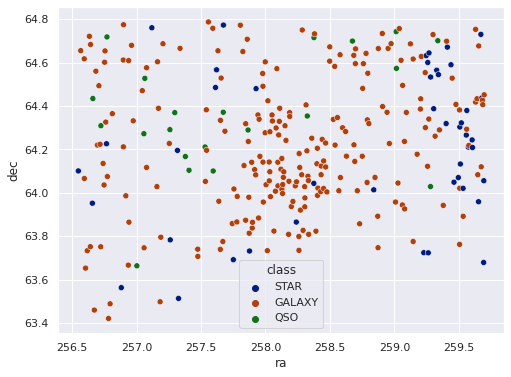

In [16]:
fig,ax = plt.subplots(figsize=(8,6))

sns.scatterplot(
    data=df,
    x="ra",
    y="dec",
    hue="class"
)
plt.show()

# Machine Learning: Scikit-Learn

The previous query only returned a subset of the full data. Out of the columns selected, there was one classification column and the rest can be considered features to train a machine learning model to predict whether an object is a galaxy, QSO, or star.

First, expand the query search to include more training data. 

In [17]:
query = (
    """
    SELECT s.ra, s.dec, s.z, s.cx, s.cy, s.cz, s.class,
           p.dered_u, p.dered_g, p.dered_r, p.dered_i, 
           p.dered_z, p.u, p.g, p.r, p.i
        FROM specObjAll AS s
    INNER JOIN photoObjAll AS p ON s.bestObjID = p.objID
    WHERE (s.ra BETWEEN 200 AND 300) AND 
          (s.dec BETWEEN 63.4 and 64.8) AND 
          s.bestObjID NOT IN (
              SELECT si.bestObjID 
                  FROM specObjALL AS si
              INNER JOIN (
                  SELECT bestObjID, COUNT(*) AS count 
                      FROM specObjALL
                  GROUP BY bestObjID
                  HAVING COUNT(*) > 1
              ) AS filter ON filter.bestObjID = si.bestObjID
          )
    """
)

# execute the query to SDSS dr16 and store it in "test"
df = CasJobs.executeQuery(query,"dr16")
df.head()

,ra,dec,z,cx,cy,cz,class,dered_u,dered_g,dered_r,dered_i,dered_z,u,g,r,i
0,213.75787,63.720686,0.035496,-0.368097,-0.246028,0.896646,GALAXY,19.19015,17.95923,17.63169,17.41176,17.21005,19.24920,18.00524,17.66352,17.43541
1,213.70636,63.623283,0.662767,-0.369586,-0.246542,0.895892,QSO,19.98146,19.30202,19.14620,18.91760,18.84010,20.03450,19.34336,19.17479,18.93885
2,213.80501,63.677005,1.331143,-0.368463,-0.246711,0.896309,QSO,19.53815,19.28701,18.95542,18.87612,19.10666,19.59368,19.33027,18.98535,18.89836
3,213.77203,63.624967,0.132627,-0.369281,-0.246951,0.895905,GALAXY,20.51892,18.59567,17.56281,17.13837,16.81703,20.57123,18.63643,17.59100,17.15932
4,213.73895,63.728250,0.243672,-0.368080,-0.245841,0.896705,GALAXY,22.40384,19.65560,18.19089,17.64901,17.30230,22.46340,19.70201,18.22300,17.67286


Extract classes from data frame and convert them to integers. Add new column of classifier indicies to dataframe df

In [18]:
"""
# This way works
df[['class_idx']]  = df[['class']].apply(lambda x: pd.factorize(x)[0] )
"""
# using sklearn to do the conversion 
le = preprocessing.LabelEncoder()
df['class_idx'] = le.fit_transform(df['class'])

In [19]:
df.head(16)

,ra,dec,z,cx,cy,cz,class,dered_u,dered_g,dered_r,dered_i,dered_z,u,g,r,i,class_idx
0,213.75787,63.720686,0.035496,-0.368097,-0.246028,0.896646,GALAXY,19.19015,17.95923,17.63169,17.41176,17.21005,19.24920,18.00524,17.66352,17.43541,0
1,213.70636,63.623283,0.662767,-0.369586,-0.246542,0.895892,QSO,19.98146,19.30202,19.14620,18.91760,18.84010,20.03450,19.34336,19.17479,18.93885,1
2,213.80501,63.677005,1.331143,-0.368463,-0.246711,0.896309,QSO,19.53815,19.28701,18.95542,18.87612,19.10666,19.59368,19.33027,18.98535,18.89836,1
3,213.77203,63.624967,0.132627,-0.369281,-0.246951,0.895905,GALAXY,20.51892,18.59567,17.56281,17.13837,16.81703,20.57123,18.63643,17.59100,17.15932,0
4,213.73895,63.728250,0.243672,-0.368080,-0.245841,0.896705,GALAXY,22.40384,19.65560,18.19089,17.64901,17.30230,22.46340,19.70201,18.22300,17.67286,0
5,213.83314,63.711198,0.263317,-0.367897,-0.246594,0.896573,GALAXY,21.67268,19.69413,18.22219,17.67938,17.33763,21.73083,19.73944,18.25353,17.70267,0
6,213.64802,63.659795,0.036199,-0.369361,-0.245850,0.896175,GALAXY,18.88445,17.77399,17.46491,17.23860,17.03790,18.93986,17.81716,17.49478,17.26080,0
7,213.87961,63.735662,2.299062,-0.367379,-0.246679,0.896762,QSO,23.55856,21.57261,21.42353,21.36855,20.82313,23.61861,21.61940,21.45590,21.39261,1
8,213.82893,63.653230,0.036077,-0.368669,-0.247072,0.896124,GALAXY,17.78605,15.68742,14.67472,14.12176,13.65535,17.84038,15.72975,14.70400,14.14352,0
9,213.87581,63.518571,0.093523,-0.370214,-0.248547,0.895079,GALAXY,18.98245,17.07990,16.15129,15.74485,15.43537,19.03327,17.11950,16.17869,15.76521,0


In [20]:
# separate data frame into features and classifiers
X = df.drop(columns=['class','class_idx']).values
y = df['class_idx'].values

In [ ]:
# split test set
# gridsearchcv will split the data set but I am reserving a fraction 
# of it as purely unseen data
Xtrain, Xtest, ytrain,ytest = model_selection.train_test_split(X,y)
# grid search to find optimal paramters of neural network 
parameters = {'rf__n_estimators':range(1,100,2)}
# build pipeline with feature scaling and a Random Forest Classifier
pipe = pipeline.Pipeline([
                          ('std',preprocessing.StandardScaler()),
                          ('rf',ensemble.RandomForestClassifier())
])
f1_scorer = metrics.make_scorer(metrics.f1_score,average='micro')
model = model_selection.GridSearchCV(pipe,
                                     parameters,
                                     refit=True,
                                     return_train_score=True,
                                     #scoring='f1_micro',
                                     scoring=f1_scorer,
                                     n_jobs=-1)
model.fit(Xtrain,ytrain)
# prediction training set and test set 
ptrain = model.predict(Xtrain)
ptest = model.predict(Xtest)

err_train = metrics.mean_squared_error(ytrain,ptrain)
print("-> RMSE of training set = %g with score = %g"%(err_train**0.5,model.score(Xtrain,ytrain)))

err_test = metrics.mean_squared_error(ytest,ptest)
print("-> RMSE = %g of test set with score = %g"%(err_test**0.5,model.score(Xtest,ytest)))

print('\nbest parameters from cross validsation: ',model.best_params_)
print('best score from cross validation: ',model.best_score_)

ptest = model.predict(Xtest)
f1 = metrics.f1_score(ytest,ptest,average=None)
print("\nF1-scores: ",f1)
print("F1-mean: ",np.mean(f1))

results = model.cv_results_
labels = ['train','test']
std = [results["std_%s_score"%split] for split in labels]
mean = [results["mean_%s_score"%split] for split in labels]

x = np.array(results["param_rf__n_estimators"].data,dtype=float)
idx = model.best_index_
fig,ax = plt.subplots(figsize=(10,6))
for (m,s,l) in zip(mean,std,labels):
    ax.plot(x,m,label=l)
    ax.fill_between(x,m-s,m+s,alpha=0.3)
ax.scatter(x[idx],m[idx],s=50,marker="x",label="best")
ax.set(xlabel='Estimators',ylabel='Mean Score')
plt.legend()
plt.show()

In [ ]:
pfull = model.predict(X)
pfull = le.inverse_transform(pfull)
fig,ax = plt.subplots(1,2,
                      figsize=(15,5))
sns.countplot(data=df,
              x="class",
              ax=ax[0])
sns.countplot(x=pfull,
              ax=ax[1])
ax[1].set(xlabel='prediction')
plt.show()

In [ ]:
parameters = {'svm__C':np.logspace(0,3,10,endpoint=True),
              'svm__gamma':['auto','scale'],
              'svm__kernel':['rbf','sigmoid']}
# build pipeline with feature scaling and Support Vector Machine Classifier
pipe = pipeline.Pipeline([
                          ('std',preprocessing.StandardScaler()),
                          ('svm',svm.SVC())
])
model = model_selection.GridSearchCV(pipe,
                                     parameters,
                                     refit=True,
                                     return_train_score=True,
                                     scoring='f1_micro',
                                     n_jobs=-1)
model.fit(Xtrain,ytrain)
# prediction training set and test set 
ptrain = model.predict(Xtrain)
ptest = model.predict(Xtest)

err_train = metrics.mean_squared_error(ytrain,ptrain)
print("-> RMSE of training set = %g with score = %g"%(err_train**0.5,model.score(Xtrain,ytrain)))

err_test = metrics.mean_squared_error(ytest,ptest)
print("-> RMSE = %g of test set with score = %g"%(err_test**0.5,model.score(Xtest,ytest)))

print('\nbest parameters from cross validsation: ',model.best_params_)
print('best score from cross validation: ',model.best_score_)

ptest = model.predict(Xtest)
f1 = metrics.f1_score(ytest,ptest,labels=None,average=None)
print("\nF1-scores: ",f1)
print("F1-mean: ",np.mean(f1))

# Deep Learning: TensorFlow/Keras

In [ ]:
# using dummies to create output instead of 0,1,2 as the classifiers
X = df.drop(columns=['class']).values
y = pd.get_dummies(df[['class']],prefix='output')
y.head()


In [ ]:
Xtrain, Xtest, ytrain,ytest = model_selection.train_test_split(X,y)
Xtrain.shape,ytrain.shape

In [ ]:
in_layer = keras.layers.Input(shape=(Xtrain.shape[1],))
d1 = keras.layers.Dense(25,activation='sigmoid')(in_layer)
d2 = keras.layers.Dense(25,activation='sigmoid')(d1)
d3 = keras.layers.Dense(25,activation='sigmoid')(d2)
out_layer = keras.layers.Dense(ytrain.shape[1],activation='softmax')(d3)

model = keras.models.Model(inputs=in_layer,outputs=out_layer)

std = preprocessing.StandardScaler().fit(Xtrain)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[keras.metrics.Precision(),keras.metrics.Recall()])
history = model.fit(std.transform(Xtrain),ytrain,
                    batch_size=10,
                    epochs=10,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=keras.callbacks.History())
model.summary()

In [ ]:
hist = pd.DataFrame(history.history)
hist.plot(y="loss",
          xlabel='Epoch',
          ylabel='Loss',
          legend=False)
plt.show()

In [ ]:
hist.head()

In [ ]:
pt = hist["precision"]
rt = hist["recall"]
pv = hist["val_precision"]
rv = hist["val_recall"]
fig,ax = plt.subplots()
sns.lineplot(
    x = range(len(pt)),
    y = 2*pt*rt/(pt+rt)
)
sns.lineplot(
    x = range(len(pv)),
    y = 2*pv*rv/(pv+rv)
)
ax.set(xlabel="Epoch",ylabel="F1")
plt.legend(["train","validation"])
plt.show()

In [ ]:
# return loss and metric
scores = model.evaluate(std.transform(Xtest),ytest)
f1 = 2*scores[1]*scores[-1]/(scores[1] + scores[-1])
print("f1 = %.2f"%f1)

In [ ]:
kwargs= dict(
             activity_regularizer=tf.keras.regularizers.L2(0.0001)
)

In [ ]:
in_layer = keras.layers.Input(shape=(Xtrain.shape[1],))
d1 = keras.layers.Dense(25,activation='sigmoid')(in_layer)
d2 = keras.layers.Dense(25,activation='sigmoid',**kwargs)(d1)
d3 = keras.layers.Dense(25,activation='sigmoid',**kwargs)(d2)
out_layer = keras.layers.Dense(ytrain.shape[1],activation='softmax')(d3)

model = keras.models.Model(inputs=in_layer,outputs=out_layer)

std = preprocessing.StandardScaler().fit(Xtrain)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[keras.metrics.Precision(),keras.metrics.Recall()])
history = model.fit(std.transform(Xtrain),ytrain,
                    batch_size=10,
                    epochs=10,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=keras.callbacks.History())
# return loss and metric
scores = model.evaluate(std.transform(Xtest),ytest)
f1 = 2*scores[1]*scores[-1]/(scores[1] + scores[-1])
print("f1 = %.2f"%f1)